In [1]:
import torch
import math
import matplotlib.style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torchinfo import summary

In [2]:
df = pd.read_csv('ICO_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Columns: 243 entries, success to accepting_ETC
dtypes: float64(6), int64(237)
memory usage: 2.9 MB


In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns!='success'], df['success'],
    stratify=df['success'], train_size=0.8, random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, stratify=y_train, train_size=0.9, random_state=42
)

print(x_train.shape, x_val.shape, x_test.shape)

(1131, 242) (126, 242) (315, 242)


In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
batch_size = 64
train_batches = []
for i in range(math.ceil(x_train.shape[0] / batch_size)):
    x_batch = torch.tensor(x_train[i*batch_size:(i+1)*batch_size].values)
    y_batch = torch.tensor(y_train[i*batch_size:(i+1)*batch_size].values)
    train_batches.append((x_batch.float(), y_batch.long()))

val_batches = []
for i in range(math.ceil(x_val.shape[0] / batch_size)):
    x_batch = torch.tensor(x_val[i*batch_size:(i+1)*batch_size].values)
    y_batch = torch.tensor(y_val[i*batch_size:(i+1)*batch_size].values)
    val_batches.append((x_batch.float(), y_batch.long()))

test_batches = []
for i in range(math.ceil(x_test.shape[0] / batch_size)):
    x_batch = torch.tensor(x_test[i*batch_size:(i+1)*batch_size].values)
    y_batch = torch.tensor(y_test[i*batch_size:(i+1)*batch_size].values)
    test_batches.append((x_batch.float(), y_batch.long()))

In [6]:
model = nn.Sequential(
    nn.Linear(in_features=242, out_features=128),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=128),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=128),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=128),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=2),
).to(device)

summary(model, input_size=(batch_size, 242))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [64, 128]                 31,104
├─Dropout: 1-2                           [64, 128]                 --
├─ReLU: 1-3                              [64, 128]                 --
├─Linear: 1-4                            [64, 128]                 16,512
├─Dropout: 1-5                           [64, 128]                 --
├─ReLU: 1-6                              [64, 128]                 --
├─Linear: 1-7                            [64, 128]                 16,512
├─Dropout: 1-8                           [64, 128]                 --
├─ReLU: 1-9                              [64, 128]                 --
├─Linear: 1-10                           [64, 128]                 16,512
├─Dropout: 1-11                          [64, 128]                 --
├─ReLU: 1-12                             [64, 128]                 --
├─Linear: 1-13                           [64, 2]                   25

In [7]:
def val_stats(batches, device, model, loss_fn):
    correct = 0
    total = 0
    running_loss = 0
    n = 0

    with torch.no_grad():
        for features, labels in batches:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)  # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            running_loss += loss.item()
            n += 1

    return running_loss / n, correct / total

In [8]:
train_loss, val_loss, val_acc = [], [], []
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [9]:
n_epochs = 100

for i in range(n_epochs):
    running_loss = 0
    n = 0

    for features, labels in train_batches:
        features, labels = features.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = model(features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()
        n += 1

    train_loss.append(running_loss / n)
    v_loss, v_acc = val_stats(val_batches, device, model, loss_fn)
    val_loss.append(v_loss)
    val_acc.append(v_acc)
    # print(f"{len(train_loss)}  train_loss: {train_loss[-1]:.3f} "
    #       f"val_loss: {val_loss[-1]:.3f}  val_acc: {val_acc[-1]:.1%}")

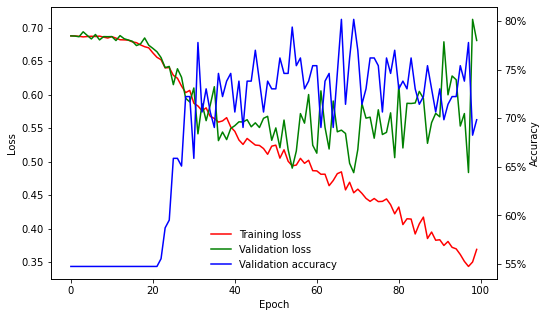

In [10]:
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax1 = plt.subplots()
plt.plot(train_loss, 'r', label = 'Training loss')
plt.plot(val_loss, 'g', label = 'Validation loss')
plt.legend(loc='lower center', bbox_to_anchor=(0.472, 0.055), edgecolor='none')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and validation loss, and validation accuracy')
ax2=ax1.twinx()
ax2.plot(val_acc, 'b', label = 'Validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.legend(loc='lower center', edgecolor='none')
# plt.savefig('loss_plot.png', dpi=300, bbox_inches = 'tight', pad_inches=0)
plt.show()

In [11]:
# for features, labels in test_batches:
#     print(features.shape, labels.shape)
val_stats(test_batches, device, model, loss_fn)

(0.6904445648193359, 0.6952380952380952)